In [2]:
from pathlib import Path
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import sympy
import os, shutil
import time

In [ ]:
# Paths for SDPA-GMP execution and I/O directories
home = Path.home()
sdpa_exec = home / "sdpa-gmp" / "sdpa_gmp"
inputs = home / "sdpa-notebooks" / "inputs"
outputs = home / "sdpa-notebooks" / "outputs"
param_file_path = home / "sdpa-notebooks" / "param.sdpa"

In [ ]:
def clear_folders():
    """
    Remove all files and subdirectories inside the input and output folders.
    """

    # Iterate over folders to be cleared
    for folder in [inputs, outputs]:
        for filename in os.listdir(folder):
            file_path = os.path.join(folder, filename)

            # Delete files or symbolic links
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)

            # Delete subdirectories recursively
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)

In [ ]:
def moment_list_generator(energy, no_of_terms: int) -> list:
    """
    Generate a list of moments for a given energy value.

    Parameters
    ----------
    energy
        The energy value used in the recurrence relation.
    no_of_terms : int
        Total number of terms (moments) to generate.

    Returns
    -------
    moment_list : list
        The list of computed moments.
    """

    # Initializion
    moment_list = [1, 0, energy, 0]

    # Recurrence relation 
    for i in range(4, no_of_terms):
        new_moment = (
            2 * energy * (i - 1) * moment_list[i - 2]
            + ((i - 1) * (i - 2) * (i - 3) * moment_list[i - 4]) / 4
        ) / i

        moment_list.append(new_moment)

    return moment_list

In [ ]:
def Hankel_matrix_generator(moment_list: list, K: int):
    """
    Construct a K * K Hankel matrix from a list of moments.

    Parameters
    ----------
    moment_list : list
        List of moments x_0, x_1, ..., used to fill the Hankel matrix.
        Assumes length >= 2K - 1.
    K : int
        Dimension of the (square) Hankel matrix.

    Returns
    -------
    matrix : list of lists
        A K * K Hankel matrix where M[i][j] = moment_list[i + j].
    """

    matrix = []

    for i in range(K):
        row = []
        for j in range(K):
            row.append(moment_list[i + j])
        matrix.append(row)

    return matrix

In [ ]:
def extract_obj_val(result, file_path):
    """
    Extract the primal objective value ('objValPrimal') from an SDPA output file.

    Parameters
    ----------
    result : CompletedProcess
        The subprocess result returned by running SDPA.
    file_path : str
        Path to the SDPA output file to read.

    Returns
    -------
    float
        The extracted primal objective value.

    Raises
    ------
    ValueError
        If 'objValPrimal' is not found in the file.
    """

    # Look for the line containing 'objValPrimal'
    with open(file_path, 'r') as f:
        for line in f:
            if 'objValPrimal' in line:
                # Extract the numeric value at the end of the line
                return float(line.strip().split()[-1])

    # If not found, print solver output for debugging
    print(result.stdout)
    raise ValueError("objValPrimal not found in output file.")

In [ ]:
# Run SDPA-GMP for each K and energy, store log10(|t|) values
K_list = [5, 8, 10, 13, 15, 18, 20]
energy_list = list(np.arange(0, 3, 0.001))
t_val_dict = {}

start = time.perf_counter()

for K in K_list:
    clear_folders()              # Reset input/output folders for each K
    t_val_list = []

    for energy in energy_list:
        # Generate moment sequence and Hankel matrix
        moment_list = moment_list_generator(energy, 2 * K + 1)
        matrix = Hankel_matrix_generator(moment_list, K)

        # Build SDPA input file content
        input_content = "1"                   # Number of blocks
        input_content += "\n1"                # Block type (1 = dense)
        input_content += f"\n{K}"             # Matrix size
        input_content += "\n-1"               # Objective coefficient

        # Add matrix entries (upper triangular)
        for i in range(K):
            for j in range(i, K):
                if matrix[i][j] != 0:
                    input_content += f"\n0 1 {i + 1} {j + 1} {-matrix[i][j]}"

        # Add identity matrix constraint
        for i in range(K):
            input_content += f"\n1 1 {i + 1} {i + 1} -1"

        # Construct input/output file paths
        input_file = str(inputs) + f"/data_{K}_{energy}.dat-s"
        output_file = str(outputs) + f"/result_{K}_{energy}.out"

        # Write SDPA input file
        Path(input_file).write_text(input_content)

        # Run SDPA-GMP
        result = subprocess.run(
            [str(sdpa_exec), str(input_file), str(output_file)],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
            check=True
        )

        # Extract objective value and store log10(|t|)
        primal_val = extract_obj_val(result, output_file)
        t_val_list.append(np.log10(np.abs(primal_val)))

    # Store results for this K
    t_val_dict[K] = t_val_list

end = time.perf_counter()

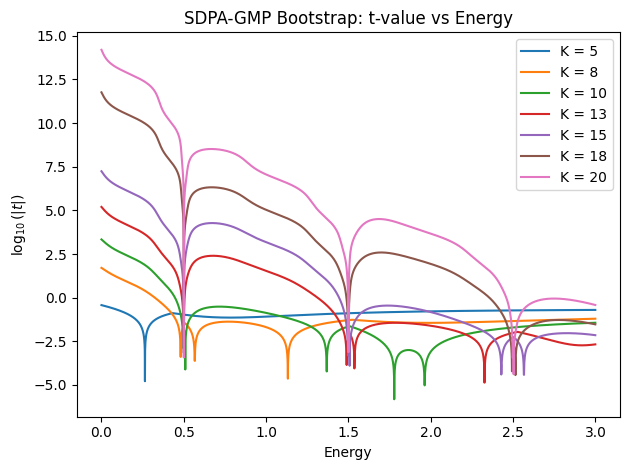

In [ ]:
def plot_sdpa_gmp_results(K_list, energy_list, flag_dict, save_dir=r"/mnt/d/BTP/Report/pictures"):
    """
    Plot log10(|t|) vs energy for all K values using SDPA-GMP results and save the figure.

    Parameters
    ----------
    K_list : list
        List of K values to plot.
    energy_list : list
        Energies corresponding to each t-value.
    flag_dict : dict
        Maps K → list of log10(|t|) values.
    save_dir : str
        Directory where the output PNG will be saved.

    Returns
    -------
    None
    """

    plt.figure()

    # Plot each K curve
    for K in K_list:
        y = np.array(flag_dict[K])
        x = np.array(energy_list)

        mask = ~np.isnan(y)        # Ignore NaN values
        plt.plot(x[mask], y[mask], label=f"K = {K}")

    # Labels and formatting
    plt.xlabel("Energy")
    plt.ylabel(r"$\log_{10}(|t|)$")
    plt.title("SDPA-GMP Bootstrap: t-value vs Energy")
    plt.legend()
    plt.tight_layout()

    # Build output file path
    filename = "SDPA_GMP_Bootstrap_t_value_vs_Energy.png"
    filepath = os.path.join(save_dir, filename)

    # Save and display
    plt.savefig(filepath, dpi=300, bbox_inches="tight")
    plt.show()


# Plot the stored SDPA-GMP results
plot_sdpa_gmp_results(K_list, energy_list, t_val_dict)

In [ ]:
# Print total runtime
print(end - start)